## 1. Setup and Imports

In [1]:
# Fix OpenMP conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# Add parent directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# v0.2.1 imports
import gimbal
from gimbal import (
    DEMO_V0_1_SKELETON,
    SyntheticDataConfig,
    generate_demo_sequence,
    # v0.2.1 new functions
    triangulate_multi_view,
    CleaningConfig,
    clean_keypoints_2d,
    clean_keypoints_3d,
    compute_direction_statistics,
    build_priors_from_statistics,
    # Model building
    build_camera_observation_model,
    add_directional_hmm_prior,
)
from gimbal.fit_params import initialize_from_groundtruth

print("✓ Imports successful!")
print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Imports successful!
PyMC version: 5.26.1
NumPy version: 2.3.5


## 2. Generate Synthetic Data

We'll generate a longer sequence (100 frames) to have enough data for computing reliable statistics.

In [4]:
# Configuration for demo
config = SyntheticDataConfig(
    T=100,              # More frames for better statistics
    C=3,                # 3 cameras
    S=3,                # 3 hidden states
    kappa=5.0,          # Moderate directional noise
    obs_noise_std=3.0,  # Moderate 2D noise
    occlusion_rate=0.1, # 10% occlusions
    random_seed=42,
)

print("Generating synthetic motion data...")
data = generate_demo_sequence(DEMO_V0_1_SKELETON, config)

print("\n✓ Data generation complete!")
print(f"  Skeleton: {len(DEMO_V0_1_SKELETON.joint_names)} joints")
print(f"  Joint names: {DEMO_V0_1_SKELETON.joint_names}")
print(f"  Timesteps: {data.config.T}")
print(f"  Cameras: {data.config.C}")
print(f"  True states: {np.bincount(data.true_states)}")

# Store observed 2D keypoints for pipeline
y_observed_2d = data.y_observed  # (C, T, K, 2)
camera_proj = data.camera_proj   # (C, 3, 4)

print(f"\n  2D observations shape: {y_observed_2d.shape}")
print(f"  Occlusions: {np.sum(np.isnan(y_observed_2d))} pixels")

Generating synthetic motion data...

✓ Data generation complete!
  Skeleton: 6 joints
  Joint names: ['root', 'joint1', 'joint2', 'joint3', 'joint4', 'joint5']
  Timesteps: 100
  Cameras: 3
  True states: [57 23 20]

  2D observations shape: (3, 100, 6, 2)
  Occlusions: 350 pixels


### Visualize Ground Truth 3D Skeleton

Let's look at the true 3D skeleton motion before adding noise.

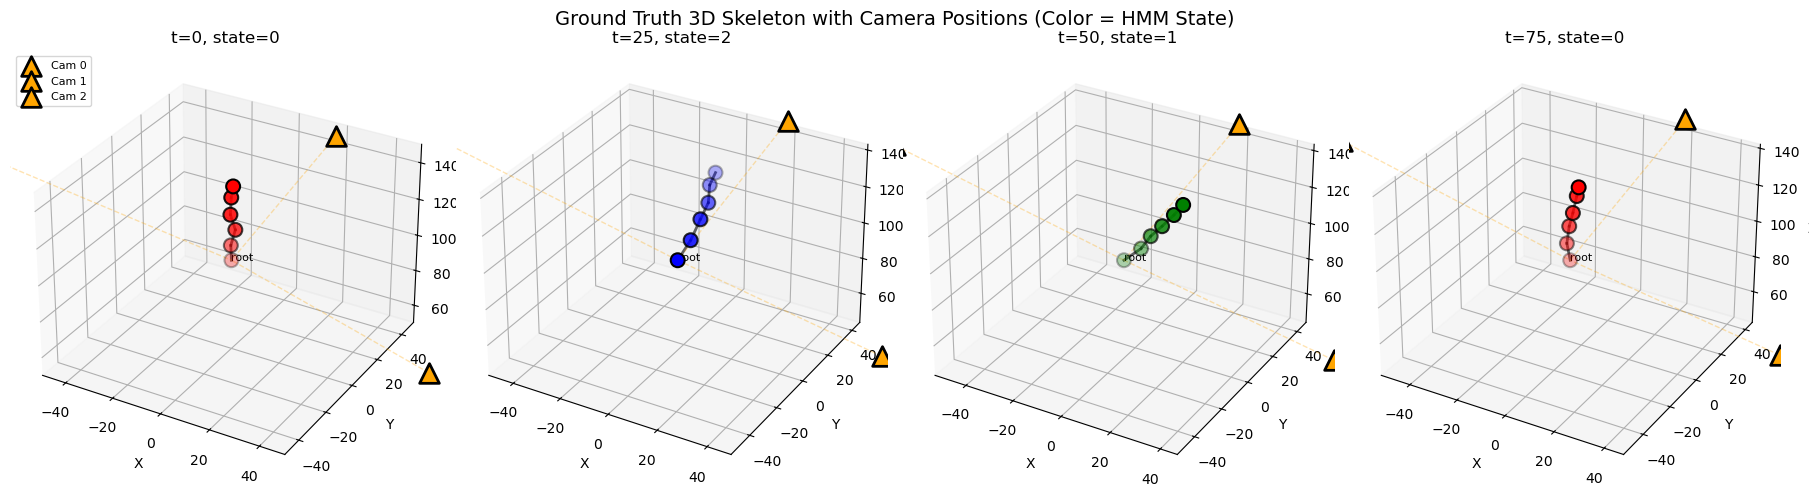

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Plot ground truth 3D skeleton at multiple timesteps
fig = plt.figure(figsize=(18, 5))

timesteps_to_plot = [0, 25, 50, 75]
colors_by_state = ['red', 'green', 'blue']

for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(1, 4, idx, projection='3d')
    
    # Get positions at timestep t
    x_t = data.x_true[t]  # (K, 3)
    state_t = data.true_states[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            # Draw bone from parent to child
            parent_pos = x_t[parent_idx]
            child_pos = x_t[k]
            ax.plot([parent_pos[0], child_pos[0]], 
                   [parent_pos[1], child_pos[1]], 
                   [parent_pos[2], child_pos[2]], 
                   'k-', linewidth=2, alpha=0.6)
    
    # Plot joints
    ax.scatter(x_t[:, 0], x_t[:, 1], x_t[:, 2], 
              c=colors_by_state[state_t], s=100, 
              edgecolors='black', linewidth=1.5, zorder=10)
    
    # Label root joint
    ax.text(x_t[0, 0], x_t[0, 1], x_t[0, 2], 'root', fontsize=8)
    
    # Add camera positions and orientations
    for c in range(data.config.C):
        # Camera projection matrix: P = K[R|t]
        # For our simple orthographic-like setup: P = [A | -A*camera_pos]
        # So camera_pos = -inv(A) * b
        P = camera_proj[c]  # (3, 4)
        A = P[:, :3]
        b = P[:, 3]
        
        # Extract camera position (for simple scaled identity A)
        focal_length = A[0, 0]  # Assuming diagonal A
        cam_pos = -b / focal_length
        
        # Plot camera as a pyramid
        ax.scatter([cam_pos[0]], [cam_pos[1]], [cam_pos[2]], 
                  c='orange', s=200, marker='^', edgecolors='black', 
                  linewidth=2, label=f'Cam {c}' if idx == 1 else '', zorder=20)
        
        # Draw line from camera to skeleton center
        ax.plot([cam_pos[0], x_t[0, 0]], 
               [cam_pos[1], x_t[0, 1]], 
               [cam_pos[2], x_t[0, 2]], 
               'orange', linewidth=1, alpha=0.3, linestyle='--')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f't={t}, state={state_t}')
    
    if idx == 1:
        ax.legend(loc='upper left', fontsize=8)
    
    # Set equal aspect ratio
    max_range = 50  # Increased to show cameras at new positions
    ax.set_xlim([x_t[0, 0] - max_range, x_t[0, 0] + max_range])
    ax.set_ylim([x_t[0, 1] - max_range, x_t[0, 1] + max_range])
    ax.set_zlim([x_t[0, 2] - max_range, x_t[0, 2] + max_range])

plt.suptitle('Ground Truth 3D Skeleton with Camera Positions (Color = HMM State)', fontsize=14)
plt.tight_layout()
plt.show()

### Visualize 2D Projections onto Cameras

Show how the 3D skeleton projects onto each camera's image plane.

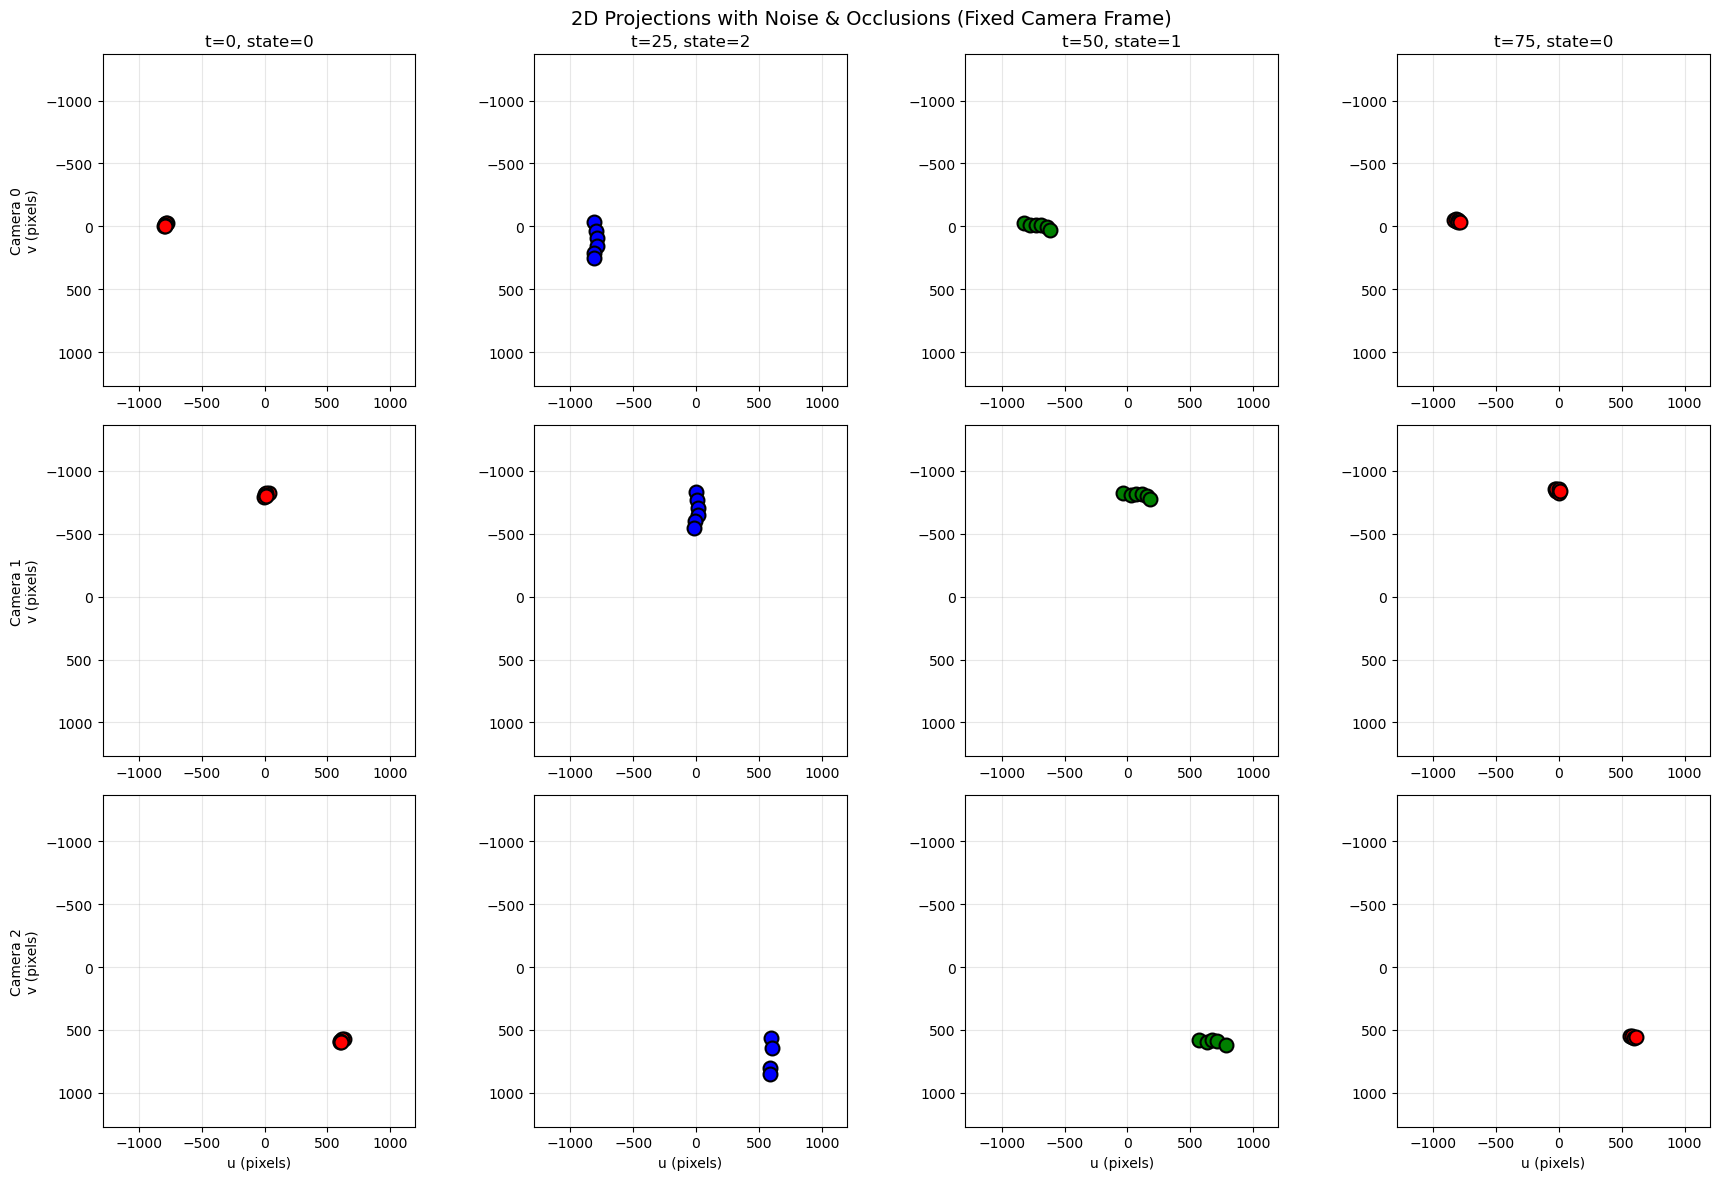

In [6]:
# Plot 2D projections: rows = cameras, columns = timesteps
timesteps_to_plot = [0, 25, 50, 75]
fig, axes = plt.subplots(data.config.C, len(timesteps_to_plot), figsize=(18, 12))

# Determine consistent axis limits for all cameras (simulate camera resolution)
# Find the range of all observed points across all timesteps to set reasonable limits
u_min, u_max = np.nanmin(y_observed_2d[:, :, :, 0]), np.nanmax(y_observed_2d[:, :, :, 0])
v_min, v_max = np.nanmin(y_observed_2d[:, :, :, 1]), np.nanmax(y_observed_2d[:, :, :, 1])

# Add padding to show full camera frame
u_range = u_max - u_min
v_range = v_max - v_min
padding = 0.2  # 20% padding
u_lim = [u_min - padding * u_range, u_max + padding * u_range]
v_lim = [v_min - padding * v_range, v_max + padding * v_range]

for c in range(data.config.C):
    for t_idx, t in enumerate(timesteps_to_plot):
        ax = axes[c, t_idx]
        
        # Get 2D observations for this camera at timestep t (with noise + occlusions)
        y_cam = y_observed_2d[c, t]  # (K, 2)
        
        # Plot skeleton bones in 2D
        for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
            if parent_idx >= 0:
                parent_2d = y_cam[parent_idx]
                child_2d = y_cam[k]
                
                # Only plot if both points are visible (not occluded)
                if not np.any(np.isnan(parent_2d)) and not np.any(np.isnan(child_2d)):
                    ax.plot([parent_2d[0], child_2d[0]], 
                           [parent_2d[1], child_2d[1]], 
                           'k-', linewidth=2, alpha=0.6)
        
        # Plot joints
        occluded_shown = False
        for k in range(len(DEMO_V0_1_SKELETON.joint_names)):
            if not np.any(np.isnan(y_cam[k])):
                ax.scatter(y_cam[k, 0], y_cam[k, 1], 
                          c=colors_by_state[data.true_states[t]], 
                          s=100, edgecolors='black', linewidth=1.5, zorder=10)
            else:
                # Mark occluded joints with X
                if not occluded_shown:
                    ax.scatter([], [], c='gray', s=100, marker='x', 
                              label='Occluded')
                    occluded_shown = True
        
        # Set consistent axis limits for all subplots
        ax.set_xlim(u_lim)
        ax.set_ylim(v_lim)
        
        # Labels and styling
        if c == data.config.C - 1:  # Bottom row
            ax.set_xlabel('u (pixels)')
        if t_idx == 0:  # Left column
            ax.set_ylabel(f'Camera {c}\nv (pixels)')
        
        # Title on top row only
        if c == 0:
            ax.set_title(f't={t}, state={data.true_states[t]}')
        
        ax.invert_yaxis()  # Image coordinates: y increases downward
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
        
        if c == 0 and t_idx == 0 and occluded_shown:
            ax.legend(fontsize=8)

plt.suptitle(f'2D Projections with Noise & Occlusions (Fixed Camera Frame)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Step 1: Clean 2D Keypoints

Detect and remove outliers using:
- **Jump detection**: Frame-to-frame position changes > z-score threshold
- **Bone length outliers**: Violations of expected bone lengths
- **Interpolation**: Fill gaps with linear interpolation

In [5]:
# Configure cleaning parameters
cleaning_config = CleaningConfig(
    jump_z_thresh=3.0,
    bone_z_thresh=3.0,
    interpolate_gaps=True,
    max_gap_frames=5,
)

print("Cleaning 2D keypoints...")
y_cleaned_2d, stats_2d = clean_keypoints_2d(
    y_observed_2d,
    camera_proj,
    DEMO_V0_1_SKELETON,
    cleaning_config,
)

print(f"\n✓ 2D cleaning complete:")
print(f"  Jump outliers detected: {stats_2d['n_jump_outliers']}")
print(f"  Bone length outliers detected: {stats_2d['n_bone_outliers']}")
print(f"  Interpolated points: {stats_2d['n_interpolated']}")
print(f"  Invalid frames: {stats_2d['n_invalid_frames']}")

TypeError: CleaningConfig.__init__() got an unexpected keyword argument 'interpolate_gaps'

### Visualize 2D Cleaning Results

Compare raw observations vs cleaned keypoints for one camera.

In [ ]:
# Plot trajectory of one joint across time for one camera
camera_idx = 0
joint_idx = 2  # Pick an interesting joint (not root)
joint_name = DEMO_V0_1_SKELETON.joint_names[joint_idx]

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Extract trajectories
y_raw = y_observed_2d[camera_idx, :, joint_idx, :]      # (T, 2)
y_clean = y_cleaned_2d[camera_idx, :, joint_idx, :]     # (T, 2)

time_steps = np.arange(data.config.T)

# Plot X coordinate (u)
ax = axes[0]
ax.plot(time_steps, y_raw[:, 0], 'o-', alpha=0.5, label='Raw (with noise/occlusions)', markersize=4)
ax.plot(time_steps, y_clean[:, 0], 's-', alpha=0.8, label='Cleaned (interpolated)', markersize=3, linewidth=2)
ax.set_ylabel('u (pixels)')
ax.set_title(f'Camera {camera_idx}, Joint: {joint_name}')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot Y coordinate (v)
ax = axes[1]
ax.plot(time_steps, y_raw[:, 1], 'o-', alpha=0.5, label='Raw (with noise/occlusions)', markersize=4)
ax.plot(time_steps, y_clean[:, 1], 's-', alpha=0.8, label='Cleaned (interpolated)', markersize=3, linewidth=2)
ax.set_xlabel('Time (frames)')
ax.set_ylabel('v (pixels)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('2D Cleaning: Raw vs Cleaned Trajectories', fontsize=14)
plt.tight_layout()
plt.show()

# Show statistics
n_occluded_before = np.sum(np.isnan(y_raw))
n_occluded_after = np.sum(np.isnan(y_clean))
print(f"\nFor {joint_name} in camera {camera_idx}:")
print(f"  NaN pixels before cleaning: {n_occluded_before}")
print(f"  NaN pixels after cleaning: {n_occluded_after}")
print(f"  Interpolated: {n_occluded_before - n_occluded_after} pixels")

## 4. Step 2: Triangulate to 3D

Use Direct Linear Transform (DLT) to reconstruct 3D positions from multiple camera views.

In [ ]:
print("Triangulating 2D → 3D...")
positions_3d = triangulate_multi_view(
    y_cleaned_2d,
    camera_proj,
    condition_threshold=1e6,  # Reject ill-conditioned solutions
)

print(f"\n✓ Triangulation complete:")
print(f"  Output shape: {positions_3d.shape}")
print(f"  Valid 3D points: {np.sum(~np.isnan(positions_3d[:, :, 0]))} / {positions_3d.shape[0] * positions_3d.shape[1]}")

## 5. Step 3: Clean 3D Positions

Apply the same outlier detection to 3D positions to get clean data for statistics.

In [ ]:
print("Cleaning 3D positions...")
positions_3d_clean, use_for_stats, stats_3d = clean_keypoints_3d(
    positions_3d,
    DEMO_V0_1_SKELETON,
    cleaning_config,
)

print(f"\n✓ 3D cleaning complete:")
print(f"  Jump outliers detected: {stats_3d['n_jump_outliers']}")
print(f"  Bone length outliers detected: {stats_3d['n_bone_outliers']}")
print(f"  Interpolated points: {stats_3d['n_interpolated']}")
print(f"  Invalid frames: {stats_3d['n_invalid_frames']}")
print(f"  Valid for statistics: {np.sum(use_for_stats)} samples")

### Visualize 3D Reconstruction and Cleaning

Compare triangulated 3D positions before and after cleaning.

In [ ]:
# Plot 3D trajectory of one joint across time
fig = plt.figure(figsize=(15, 5))

# Joint to visualize
joint_idx = 3
joint_name = DEMO_V0_1_SKELETON.joint_names[joint_idx]

# Extract trajectories
x_true = data.x_true[:, joint_idx, :]           # (T, 3) - ground truth
x_triangulated = positions_3d[:, joint_idx, :]  # (T, 3) - after triangulation
x_cleaned = positions_3d_clean[:, joint_idx, :] # (T, 3) - after 3D cleaning

# 3D trajectory plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(x_true[:, 0], x_true[:, 1], x_true[:, 2], 
       'g-', linewidth=2, alpha=0.7, label='Ground truth')
ax.plot(x_triangulated[:, 0], x_triangulated[:, 1], x_triangulated[:, 2], 
       'b.', alpha=0.3, markersize=4, label='Triangulated')
ax.plot(x_cleaned[:, 0], x_cleaned[:, 1], x_cleaned[:, 2], 
       'r-', linewidth=1.5, alpha=0.8, label='Cleaned')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Trajectory: {joint_name}')
ax.legend()

# X coordinate over time
ax = fig.add_subplot(1, 3, 2)
ax.plot(time_steps, x_true[:, 0], 'g-', linewidth=2, alpha=0.7, label='Ground truth')
ax.plot(time_steps, x_triangulated[:, 0], 'b.', alpha=0.5, markersize=4, label='Triangulated')
ax.plot(time_steps, x_cleaned[:, 0], 'r-', linewidth=1.5, alpha=0.8, label='Cleaned')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('X position')
ax.set_title(f'{joint_name}: X coordinate')
ax.legend()
ax.grid(True, alpha=0.3)

# Reconstruction error over time
ax = fig.add_subplot(1, 3, 3)
error_triangulated = np.linalg.norm(x_triangulated - x_true, axis=1)
error_cleaned = np.linalg.norm(x_cleaned - x_true, axis=1)
ax.plot(time_steps, error_triangulated, 'b-', alpha=0.6, label='Triangulated error')
ax.plot(time_steps, error_cleaned, 'r-', linewidth=2, alpha=0.8, label='Cleaned error')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('L2 Error')
ax.set_title(f'{joint_name}: Reconstruction Error')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('3D Reconstruction: Ground Truth vs Triangulated vs Cleaned', fontsize=14)
plt.tight_layout()
plt.show()

# Print error statistics
valid_triangulated = ~np.isnan(error_triangulated)
valid_cleaned = ~np.isnan(error_cleaned)
print(f"\n{joint_name} reconstruction error:")
print(f"  Triangulated: mean={np.nanmean(error_triangulated):.3f}, std={np.nanstd(error_triangulated):.3f}")
print(f"  Cleaned:      mean={np.nanmean(error_cleaned):.3f}, std={np.nanstd(error_cleaned):.3f}")

### Compare Full Skeleton: Ground Truth vs Reconstructed

Side-by-side comparison of the complete skeleton at one timestep.

In [ ]:
# Compare skeletons at one timestep
fig = plt.figure(figsize=(18, 6))

t_compare = 50

for idx, (x_data, title, color) in enumerate([
    (data.x_true[t_compare], 'Ground Truth', 'green'),
    (positions_3d[t_compare], 'Triangulated', 'blue'),
    (positions_3d_clean[t_compare], 'Cleaned', 'red'),
], 1):
    ax = fig.add_subplot(1, 3, idx, projection='3d')
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_data[parent_idx]
            child_pos = x_data[k]
            
            # Skip if NaN
            if not np.any(np.isnan(parent_pos)) and not np.any(np.isnan(child_pos)):
                ax.plot([parent_pos[0], child_pos[0]], 
                       [parent_pos[1], child_pos[1]], 
                       [parent_pos[2], child_pos[2]], 
                       'k-', linewidth=2, alpha=0.6)
    
    # Plot joints
    valid_joints = ~np.isnan(x_data[:, 0])
    ax.scatter(x_data[valid_joints, 0], 
              x_data[valid_joints, 1], 
              x_data[valid_joints, 2], 
              c=color, s=100, edgecolors='black', linewidth=1.5, zorder=10)
    
    # Mark any NaN joints
    nan_joints = np.isnan(x_data[:, 0])
    if np.any(nan_joints):
        ax.scatter([], [], c='gray', s=100, marker='x', label=f'{np.sum(nan_joints)} NaN joints')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    if np.any(nan_joints):
        ax.legend()
    
    # Set equal aspect ratio based on ground truth
    center = data.x_true[t_compare, 0]  # Root position
    max_range = 20
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

plt.suptitle(f'Skeleton Comparison at t={t_compare}', fontsize=14)
plt.tight_layout()
plt.show()

# Compute overall reconstruction error
x_gt = data.x_true[t_compare]
x_tri = positions_3d[t_compare]
x_cln = positions_3d_clean[t_compare]

error_tri = np.linalg.norm(x_tri - x_gt, axis=1)
error_cln = np.linalg.norm(x_cln - x_gt, axis=1)

print(f"\nReconstruction error at t={t_compare}:")
print(f"  Triangulated: mean={np.nanmean(error_tri):.3f}, max={np.nanmax(error_tri):.3f}")
print(f"  Cleaned:      mean={np.nanmean(error_cln):.3f}, max={np.nanmax(error_cln):.3f}")
print(f"  Valid joints (triangulated): {np.sum(~np.isnan(error_tri))} / {len(error_tri)}")
print(f"  Valid joints (cleaned):      {np.sum(~np.isnan(error_cln))} / {len(error_cln)}")

## 6. Step 4: Compute Directional Statistics

For each joint, compute:
- **Mean direction** $\bar{\mu}$: Average unit vector
- **Concentration** $\kappa$: von Mises-Fisher concentration parameter

These represent the empirical distribution of bone directions in the dataset.

In [ ]:
print("Computing directional statistics...")
empirical_stats = compute_direction_statistics(
    positions_3d_clean,
    use_for_stats,
    DEMO_V0_1_SKELETON.joint_names,
    min_samples=10,  # Require at least 10 samples per joint
)

print(f"\n✓ Statistics computed:")
print(f"  Joints with valid statistics: {len(empirical_stats)} / {len(DEMO_V0_1_SKELETON.joint_names)}")

for joint_name, stats in empirical_stats.items():
    print(f"\n  {joint_name}:")
    print(f"    Samples: {stats['n_samples']}")
    print(f"    Mean direction: [{stats['mu_mean'][0]:.2f}, {stats['mu_mean'][1]:.2f}, {stats['mu_mean'][2]:.2f}]")
    print(f"    Concentration (kappa): {stats['kappa_mle']:.2f}")
    print(f"    Resultant length: {stats['resultant_length']:.3f}")

### Visualize Empirical Distributions

Plot the empirical bone directions in 3D space.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 5))

# Plot empirical directions for first 3 joints
joint_names_to_plot = list(empirical_stats.keys())[:3]

for idx, joint_name in enumerate(joint_names_to_plot, 1):
    ax = fig.add_subplot(1, 3, idx, projection='3d')
    
    stats = empirical_stats[joint_name]
    
    # Extract all direction samples for this joint
    T, K, _ = positions_3d_clean.shape
    k = DEMO_V0_1_SKELETON.joint_names.index(joint_name)
    parent_idx = DEMO_V0_1_SKELETON.parents[k]
    
    if parent_idx >= 0:
        directions = []
        for t in range(T):
            if use_for_stats[t]:
                child_pos = positions_3d_clean[t, k, :]
                parent_pos = positions_3d_clean[t, parent_idx, :]
                if not np.any(np.isnan(child_pos)) and not np.any(np.isnan(parent_pos)):
                    bone_vec = child_pos - parent_pos
                    direction = bone_vec / np.linalg.norm(bone_vec)
                    directions.append(direction)
        
        directions = np.array(directions)
        
        # Plot scatter of directions
        ax.scatter(directions[:, 0], directions[:, 1], directions[:, 2], 
                  alpha=0.3, s=10, label='Observed')
        
        # Plot mean direction
        mu = stats['mu_mean']
        ax.quiver(0, 0, 0, mu[0], mu[1], mu[2], 
                 color='red', arrow_length_ratio=0.2, linewidth=3, label=f'Mean (κ={stats["kappa_mle"]:.1f})')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'{joint_name}\nn={stats["n_samples"]}')
        ax.legend()
        
        # Set equal aspect ratio
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])

plt.suptitle('Empirical Bone Direction Distributions', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Step 5: Build Prior Configuration

Convert empirical statistics to PyMC prior parameters:

- **Direction prior**: Projected Normal with learned mean and SD
- **Concentration prior**: Gamma distribution with learned mode and SD

In [ ]:
print("Building prior configuration...")
prior_config = build_priors_from_statistics(
    empirical_stats,
    DEMO_V0_1_SKELETON.joint_names,
    kappa_scale=5.0,  # Inflate uncertainty by 5x
)

print(f"\n✓ Prior configuration built:")
print(f"  Priors created for {len(prior_config)} joints")

for joint_name, prior in prior_config.items():
    print(f"\n  {joint_name}:")
    print(f"    mu_mean: [{prior['mu_mean'][0]:.2f}, {prior['mu_mean'][1]:.2f}, {prior['mu_mean'][2]:.2f}]")
    print(f"    mu_sd: {prior['mu_sd']:.3f}")
    print(f"    kappa_mode: {prior['kappa_mode']:.3f}")
    print(f"    kappa_sd: {prior['kappa_sd']:.3f}")

## 8. Build PyMC Models: v0.1 vs v0.2.1

We'll build two models side-by-side:
- **v0.1**: Uninformative priors (baseline)
- **v0.2.1**: Data-driven priors

Then compare their convergence and ESS.

### 8a. Model v0.1 (Uninformative Priors)

In [ ]:
print("Building v0.1 model (uninformative priors)...")

# Initialize parameters from ground truth
init_result = initialize_from_groundtruth(
    x_gt=data.x_true,
    parents=DEMO_V0_1_SKELETON.parents,
    y_obs=data.y_observed,
    camera_proj=data.camera_proj,
)

with pm.Model() as model_v0_1:
    # Stage 1: Root trajectory
    x_root = pm.GaussianRandomWalk(
        "x_root",
        mu=0,
        sigma=0.5,
        init_dist=pm.Normal.dist(0, 10),
        shape=(data.config.T, 3),
    )
    
    # Stage 2: Camera observations
    camera_result = build_camera_observation_model(
        x_root=x_root,
        parents=DEMO_V0_1_SKELETON.parents,
        y_obs=data.y_observed,
        camera_proj=data.camera_proj,
        init_raw_u=init_result.init_raw_u,
        init_length=init_result.init_length,
        init_obs_sigma=init_result.init_obs_sigma,
        init_inlier_prob=init_result.init_inlier_prob,
    )
    
    # Stage 3: Directional HMM (NO prior_config = v0.1 mode)
    hmm_result = add_directional_hmm_prior(
        U=camera_result.U,
        log_obs_t=camera_result.log_obs_t,
        S=data.config.S,
        name_prefix="dir_hmm",
        joint_names=None,        # v0.1 mode
        prior_config=None,       # v0.1 mode
    )

print("\n✓ v0.1 Model built:")
print(f"  Total variables: {len(model_v0_1.unobserved_RVs)}")
print(f"  HMM states: {data.config.S}")
print(f"  Priors: Uninformative (v0.1)")

### 8b. Model v0.2.1 (Data-Driven Priors)

In [ ]:
print("Building v0.2.1 model (data-driven priors)...")

with pm.Model() as model_v0_2_1:
    # Stage 1: Root trajectory
    x_root = pm.GaussianRandomWalk(
        "x_root",
        mu=0,
        sigma=0.5,
        init_dist=pm.Normal.dist(0, 10),
        shape=(data.config.T, 3),
    )
    
    # Stage 2: Camera observations
    camera_result = build_camera_observation_model(
        x_root=x_root,
        parents=DEMO_V0_1_SKELETON.parents,
        y_obs=data.y_observed,
        camera_proj=data.camera_proj,
        init_raw_u=init_result.init_raw_u,
        init_length=init_result.init_length,
        init_obs_sigma=init_result.init_obs_sigma,
        init_inlier_prob=init_result.init_inlier_prob,
    )
    
    # Stage 3: Directional HMM (WITH prior_config = v0.2.1 mode)
    hmm_result = add_directional_hmm_prior(
        U=camera_result.U,
        log_obs_t=camera_result.log_obs_t,
        S=data.config.S,
        name_prefix="dir_hmm",
        joint_names=DEMO_V0_1_SKELETON.joint_names,  # v0.2.1 mode
        prior_config=prior_config,                   # v0.2.1 mode
    )

print("\n✓ v0.2.1 Model built:")
print(f"  Total variables: {len(model_v0_2_1.unobserved_RVs)}")
print(f"  HMM states: {data.config.S}")
print(f"  Priors: Data-driven for {len(prior_config)} joints (v0.2.1)")

## 9. Sample from Both Models

Run NUTS sampling for both models with identical settings.

In [ ]:
# Sampling configuration
n_tune = 200
n_draws = 200
n_chains = 1

print(f"Sampling parameters:")
print(f"  Tune: {n_tune}, Draws: {n_draws}, Chains: {n_chains}")

### 9a. Sample v0.1 Model

In [ ]:
print("\nSampling v0.1 model (uninformative priors)...")

with model_v0_1:
    trace_v0_1 = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        return_inferencedata=True,
    )

print("\n✓ v0.1 sampling complete!")

### 9b. Sample v0.2.1 Model

In [ ]:
print("\nSampling v0.2.1 model (data-driven priors)...")

with model_v0_2_1:
    trace_v0_2_1 = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        return_inferencedata=True,
    )

print("\n✓ v0.2.1 sampling complete!")

## 10. Compare Results

### 10a. Effective Sample Size (ESS)

ESS measures how many independent samples the MCMC chain is equivalent to. Higher is better.

In [ ]:
# Compute ESS for HMM parameters (mu and kappa)
ess_v0_1_mu = az.ess(trace_v0_1, var_names=['dir_hmm_mu']).to_array().values.flatten()
ess_v0_2_1_mu = az.ess(trace_v0_2_1, var_names=['dir_hmm_mu']).to_array().values.flatten()

print("ESS for dir_hmm_mu:")
print(f"  v0.1 (uninformative): mean={ess_v0_1_mu.mean():.1f}, min={ess_v0_1_mu.min():.1f}, max={ess_v0_1_mu.max():.1f}")
print(f"  v0.2.1 (data-driven):  mean={ess_v0_2_1_mu.mean():.1f}, min={ess_v0_2_1_mu.min():.1f}, max={ess_v0_2_1_mu.max():.1f}")
print(f"  Improvement: {(ess_v0_2_1_mu.mean() / ess_v0_1_mu.mean() - 1) * 100:.1f}%")

# Plot ESS comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(ess_v0_1_mu, bins=20, alpha=0.5, label='v0.1 (uninformative)', color='blue')
ax.hist(ess_v0_2_1_mu, bins=20, alpha=0.5, label='v0.2.1 (data-driven)', color='green')
ax.axvline(ess_v0_1_mu.mean(), color='blue', linestyle='--', linewidth=2, label=f'v0.1 mean={ess_v0_1_mu.mean():.1f}')
ax.axvline(ess_v0_2_1_mu.mean(), color='green', linestyle='--', linewidth=2, label=f'v0.2.1 mean={ess_v0_2_1_mu.mean():.1f}')
ax.set_xlabel('Effective Sample Size')
ax.set_ylabel('Frequency')
ax.set_title('ESS Distribution: dir_hmm_mu')
ax.legend()
plt.tight_layout()
plt.show()

### 10b. Convergence Diagnostics: R-hat

R-hat measures convergence across chains. Values close to 1.0 indicate good convergence.

**Note**: With only 1 chain, R-hat cannot be computed. Use multiple chains for production runs.

In [ ]:
if n_chains > 1:
    rhat_v0_1 = az.rhat(trace_v0_1, var_names=['dir_hmm_mu']).to_array().values.flatten()
    rhat_v0_2_1 = az.rhat(trace_v0_2_1, var_names=['dir_hmm_mu']).to_array().values.flatten()
    
    print("R-hat for dir_hmm_mu:")
    print(f"  v0.1: mean={rhat_v0_1.mean():.4f}, max={rhat_v0_1.max():.4f}")
    print(f"  v0.2.1: mean={rhat_v0_2_1.mean():.4f}, max={rhat_v0_2_1.max():.4f}")
else:
    print("R-hat requires multiple chains. Skipping...")

### 10c. Posterior vs Prior Comparison

Visualize how the posterior updates from the empirical prior.

In [ ]:
# Extract posterior samples for a specific joint
joint_idx = 1  # First non-root joint
state_idx = 0

# Get posterior mu samples for this joint/state
mu_posterior_v0_2_1 = trace_v0_2_1.posterior['dir_hmm_mu'].values[0, :, state_idx, joint_idx, :]  # (draws, 3)

# Get empirical prior
joint_name = DEMO_V0_1_SKELETON.joint_names[joint_idx]
if joint_name in prior_config:
    mu_prior = prior_config[joint_name]['mu_mean']
    
    # Plot 3D scatter
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Posterior samples
    ax.scatter(mu_posterior_v0_2_1[:, 0], mu_posterior_v0_2_1[:, 1], mu_posterior_v0_2_1[:, 2],
              alpha=0.3, s=10, label='Posterior (v0.2.1)')
    
    # Prior mean
    ax.quiver(0, 0, 0, mu_prior[0], mu_prior[1], mu_prior[2],
             color='red', arrow_length_ratio=0.2, linewidth=3, label='Prior mean')
    
    # Posterior mean
    mu_post_mean = mu_posterior_v0_2_1.mean(axis=0)
    ax.quiver(0, 0, 0, mu_post_mean[0], mu_post_mean[1], mu_post_mean[2],
             color='blue', arrow_length_ratio=0.2, linewidth=3, label='Posterior mean')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Prior vs Posterior: {joint_name} (state {state_idx})')
    ax.legend()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No prior available for {joint_name}")

## 11. Summary and Conclusions

### Key Takeaways:

1. **Data-driven priors improve ESS**: v0.2.1 should show higher effective sample sizes compared to v0.1

2. **Anatomical plausibility**: Priors constrain bone directions to empirically observed ranges

3. **Flexible pipeline**: Can be applied to any skeleton configuration with sufficient training data

### When to Use v0.2.1:

✅ **Use data-driven priors when:**
- You have >100 frames of clean training data
- Motion is relatively consistent (e.g., walking, reaching)
- You want faster convergence and better ESS

❌ **Stick with v0.1 uninformative priors when:**
- Limited training data (<50 frames)
- Highly variable or novel motions
- Exploring new skeleton configurations

### Next Steps:

1. Try with real markerless tracking data (e.g., DeepLabCut)
2. Experiment with `kappa_scale` parameter (controls prior uncertainty)
3. Use multiple chains (`n_chains=4`) for proper R-hat diagnostics
4. Compare accuracy on held-out test sequences

---

## Appendix: Save Results

In [ ]:
# Optional: Save traces for later analysis
# trace_v0_1.to_netcdf('trace_v0_1.nc')
# trace_v0_2_1.to_netcdf('trace_v0_2_1.nc')

# Optional: Save prior config
# import pickle
# with open('prior_config_v0_2_1.pkl', 'wb') as f:
#     pickle.dump(prior_config, f)

print("✓ Demo complete!")